# zone by zone analysis

In [47]:
# this set up the  interactive visualisation mode for graphics.
%matplotlib notebook 
#%matplotlib inline
from operator import itemgetter
from itertools import groupby
import pandas as pd
import numpy as np
pd.set_option('display.max_rows',7) #only visualise 7 rows when displaying tables
from vega import vegalite
import vega
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import feature
from skimage import measure
from ipywidgets import interact, interactive, fixed
from copy import deepcopy

# Deploying the strategy 

In [48]:
def analyse(im):
    im  = im[:,:,0]
    
    edges = feature.canny(im,sigma=0.5)
    dup_edges=deepcopy(edges)
    
    update_edges,ranges = clustered(dup_edges)
    
    res = np.sum(update_edges,axis=0)/2
    res = res[0:-1] ## remove the last value wich is always 0 by the algo
    res[0] = res[1]
    s = pd.Series(res)
    r = s.rolling(window=50,center=True,min_periods=3).mean()
    df = pd.DataFrame({'Analyse':s, 'Moyenne glissante':r})
    
    return {'im': im, 'edges':edges,'new_edges':update_edges, 'df':df}


def plot_analysis(im, edges,new_edges,r, width=10):
    fig, (ax1, ax2, ax3,ax4) = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=False, figsize=(width, 4))
    ax1.imshow(im,cmap=plt.cm.gray)
    ax2.imshow(edges,cmap=plt.cm.gray)
    ax3.imshow(new_edges,cmap=plt.cm.gray)
    r.plot(ax=ax4)
    ymax=max(r)
    xmax=r.idxmax(axis=0, skipna=True)
    
    ax1.set_title('Image originale')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    
    ax2.set_title('Edges')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    
    ax3.set_title('Cleaned Edges')
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    
    ax4.set_ylim(0,ymax+25)
    ax4.set_title('Number of Striations')
    ax4.set_xlabel('x')
    ax4.set_ylabel('nb de stries [-]')
    ax4.annotate('Max:', xy=(xmax, ymax), xytext=(xmax, ymax+10),
             arrowprops=dict(facecolor='black', shrink=0.05),
            )
    
    return fig

def clustered(edge):
    
    for k in range(edge.shape[1]):
   
        ranges = []
        j, = np.where(edge[:,k]==True)
        data=j
        for key, group in groupby(enumerate(data), lambda i: i[0] - i[1]):
            group = list(map(itemgetter(1), group))
            if len(group)>1:
            
                edge[group[1]:group[-1]+1,k]=False
            
            ranges.append(group)
    
    return edge,ranges

In [137]:
from PIL import Image
import glob
image_list = []
for filename in glob.glob('samples/*.tif'):
    im=plt.imread(filename)
    image_list.append(im)
    
res = [ analyse(x) for x in image_list]

nb_stries=[max(res[i]['df']['Moyenne glissante'])*1000 for i in range(10)]

In [68]:
def browse_samples(images):
    n = len(images)
    def view_image(i):
        fig =plot_analysis(res[i]['im'],res[i]['edges'],res[i]['new_edges'],res[i]['df']['Moyenne glissante'],width=12)
        
    interact(view_image, i=(0,n-1))

<IPython.core.display.Javascript object>


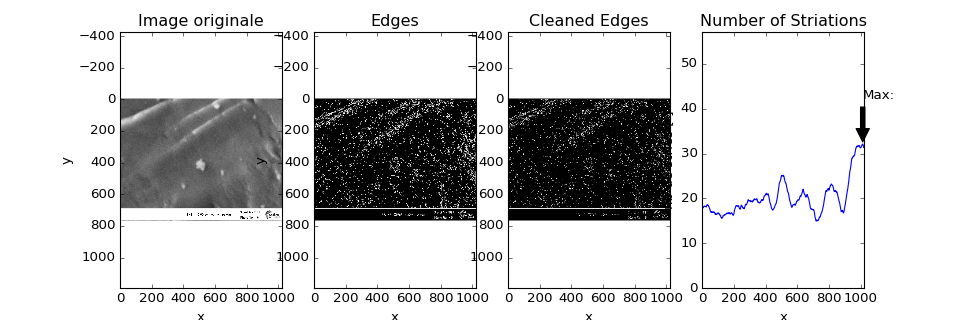

In [69]:
browse_samples(image_list)

In [56]:
def method_cetim(edges_cetim,r):
    ymax=max(r)
    
    xmax=r.idxmax(axis=0, skipna=True)
    edge_dup=deepcopy(edges_cetim)
    edge_dup=edge_dup[0:edges_cetim.shape[1],xmax-50:xmax+50]
    
    total=0
    k=1
    for i in range(10,50,10):
        j,=(np.where(edge_dup[:,i]==True))
        
        for i in range(k,k+10,2):
            total=total+(j[i+1]-j[i])
    return total/20

In [132]:
zone=[0,3.4,6,9,12,15,18,21,24,27,30,30.1]
delta=[(zone[i+1]-zone[i])*1000 for i in range(len(zone)-1)]
delta.insert(0,zone[0])
##delta.insert(len(delta),delta[-1])

moy=[method_cetim(res[i]['new_edges'],res[i]['df']['Moyenne glissante']) for i in range(10)]
moy.insert(0,moy[0])
moy.insert(len(moy),moy[-1])
i_moy=[(moy[i]+moy[i-1])/2 for i in range(1,len(moy)) ]
i_moy.insert(0,moy[0])

In [133]:
stries=[delta[i]/i_moy[i]*100 for i in range(len(delta))]

In [135]:
tabular=pd.DataFrame({'Position':zone,'i':moy,'delta':delta,'i moy':i_moy,'stries':stries})
tabular=tabular.round(2)

In [136]:
import plotly.plotly as py
import plotly.figure_factory as ff
table = ff.create_table(tabular)
py.iplot(table, filename='pandas_table')